In [30]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import tool
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
from itertools import combinations
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [31]:
def findsubsets(S, m):
    return set(combinations(S, m))

def jaccard_index(a,b):
    den=len(a|b)
    if den ==0:
        return 0.0
    else:
        return float(len(a&b) / den)

def siblings(G,a):
    sibs=set()
    for x in G.successors(a):
        for bb in G.predecessors(x):
            if bb !=a:
                sibs.add(bb)
    return sibs

def is_siblings(G,a,b):
    sibs=siblings(G,a)
    if b in sibs:
        return True
    else:
        return False

def min_max_mean_std_hist(data,title,x_describe,y_describe,color_id):
    plt.figure(figsize=(12, 8))
    color = sns.color_palette()
    cnt_srs = pd.Series(data).value_counts()
    min=np.min(np.array(data))
    max=np.max(np.array(data))
    mean=np.mean(np.array(data))
    std=np.std(np.array(data))
    statx ='\nx: min: %.4f max: %.4f mean: %.4f std: %.4f\n' % (min, max, mean, std)
#     min=np.min(np.array(cnt_srs.values))
#     max=np.max(np.array(cnt_srs.values))
#     mean=np.mean(np.array(cnt_srs.values))
#     std=np.std(np.array(cnt_srs.values))
#     staty='\n min: %.4f max: %.4f mean: %.4f std: %.4f\n' %(min,max,mean,std)
    plt.title(title+statx)
    sns.barplot(cnt_srs.index, cnt_srs.values, color=color[color_id])
    plt.ylabel(y_describe, fontsize=12)
    plt.xlabel(x_describe, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.show()
    
def min_max_mean_std_hist_float(data,title,x_describe,y_describe,bin,color_id):
    plt.figure(figsize=(12, 8))
    counts, bins, patches=plt.hist(data,bins=bin,color=color_id)
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    color = sns.color_palette()
    cnt_srs = pd.Series(data).value_counts()
    min=np.min(np.array(data))
    max=np.max(np.array(data))
    mean=np.mean(np.array(data))
    std=np.std(np.array(data))
    statx ='\nmin: %.4f max: %.4f mean: %.4f std: %.4f\n' % (min, max, mean, std)
    min=np.min(np.array(cnt_srs.values))
    max=np.max(np.array(cnt_srs.values))
    mean=np.mean(np.array(cnt_srs.values))
    std=np.std(np.array(cnt_srs.values))
    plt.title(title+statx)
    plt.ylabel(y_describe, fontsize=12)
    plt.xlabel(x_describe, fontsize=12)
    plt.xticks(rotation='vertical')

    for count, x,b in zip(counts, bin_centers,bins):
        # Label the raw counts
        plt.annotate(str(b), xy=(b, 0), xycoords=('data', 'axes fraction'),
                     xytext=(0, -35), textcoords='offset points', va='top',
                     ha='center')
        plt.annotate(str(count), xy=(b, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -45), textcoords='offset points', va='top', ha='center')

        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        plt.annotate(percent, xy=(b, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, -55), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.tight_layout(pad=4)

    plt.show()

In [32]:
TG=nx.DiGraph()

edges=tool.load_csv('../summary/uv_graph_no_incest_topological_sorted.csv')
int_edges=[]
for e in edges:
    if e[0]=='root':
        int_edges.append([e[0],int(e[1])])
    else:
        int_edges.append([int(e[0]),int(e[1])])
TG.add_edges_from(int_edges)
TG.remove_node('root')

terminal_vertices=[x for x in TG.nodes_iter() if TG.out_degree(x)==0 and TG.in_degree(x)>0]
source_vertices=[x for x in TG.nodes_iter() if TG.in_degree(x)==0 and TG.out_degree(x)>0]
isolate_vertices=[x for x in TG.nodes_iter() if TG.in_degree(x)==0 and TG.out_degree(x)==0]

print('number of topic vertices:',len(TG))
print('number of terminal vertices:',len(terminal_vertices))
print('number of source vertices:',len(source_vertices))
print('number of isolate vertices:',len(isolate_vertices))

number of topic vertices: 1999
number of terminal vertices: 1117
number of source vertices: 64
number of isolate vertices: 51


In [33]:
par_chd=[(TG.in_degree(x),TG.out_degree(x),len(siblings(TG,x))) for x in TG.nodes_iter()]

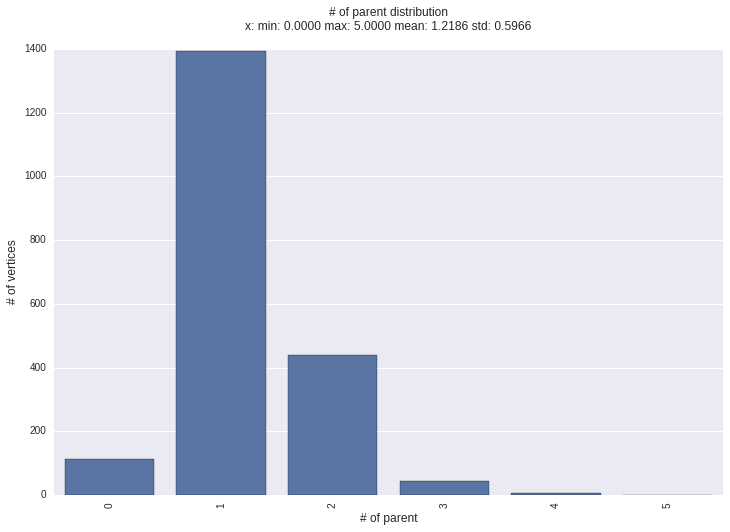

In [34]:
min_max_mean_std_hist([par[0] for par in par_chd],'# of parent distribution','# of parent','# of vertices',0)

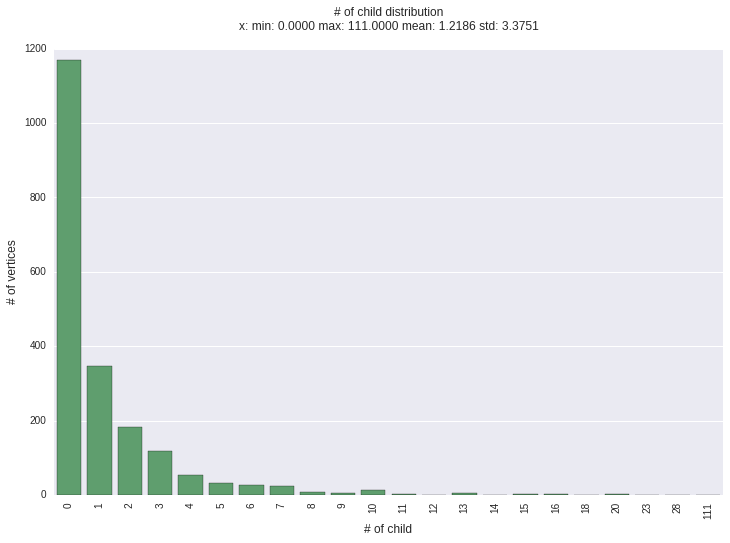

In [35]:
min_max_mean_std_hist([par[1] for par in par_chd],'# of child distribution','# of child','# of vertices',1)

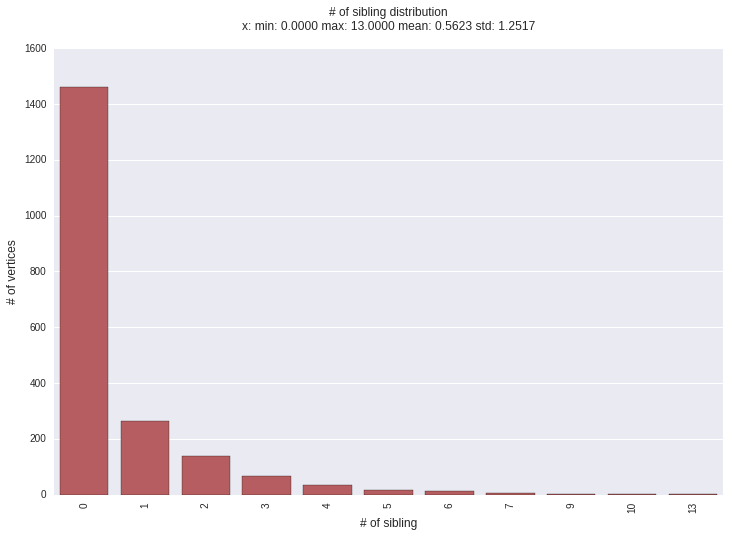

In [36]:
min_max_mean_std_hist([par[2] for par in par_chd],'# of sibling distribution','# of sibling','# of vertices',2)

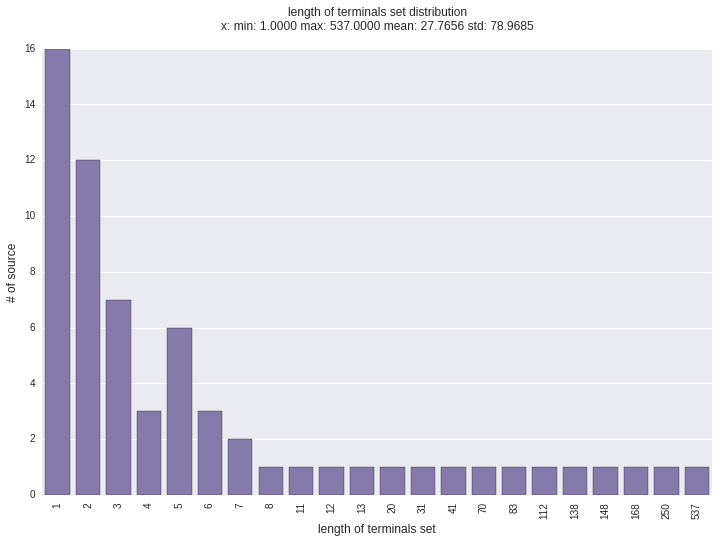

In [37]:
T_s=[(s,[t for t in terminal_vertices if nx.has_path(TG,s,t)]) for s in source_vertices]
min_max_mean_std_hist([len(s[1]) for s in T_s],'length of terminals set distribution','length of terminals set','# of source',3)

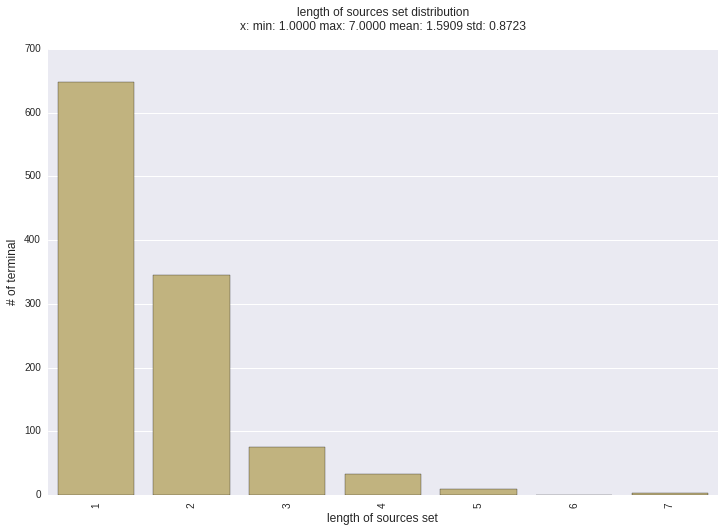

In [38]:
S_t=[(t,[s for s in source_vertices if nx.has_path(TG,s,t)]) for t in terminal_vertices]
min_max_mean_std_hist([len(t[1]) for t in S_t],'length of sources set distribution','length of sources set','# of terminal',4)

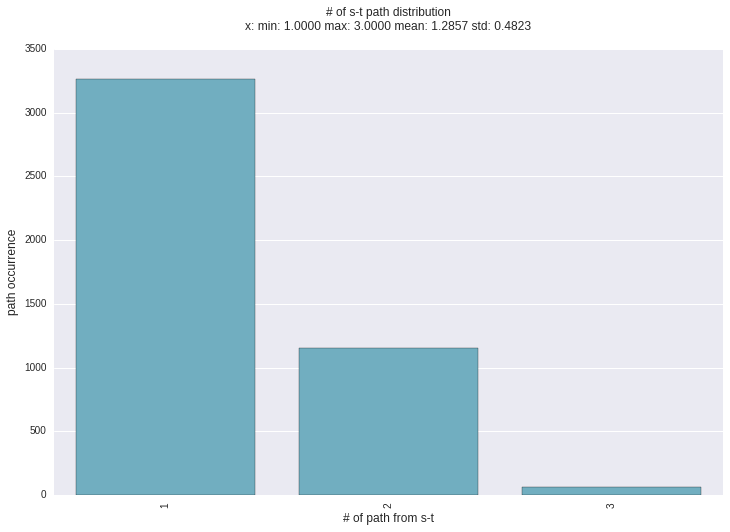

In [39]:
P_s_t=[]
for (s,set_of_rechable_t) in T_s:
    t_list=[]
    for t in set_of_rechable_t:
        paths=[path for path in nx.all_simple_paths(TG,s,t)]
        t_list.append((t,paths))
    P_s_t.append((s,t_list))


P_s_t_length=[len(paths) for (t,paths) in t_list for (s,t_list) in P_s_t]
min_max_mean_std_hist(P_s_t_length,'# of s-t path distribution','# of path from s-t','path occurrence',5)
        


[276, 6, 4, 500, 10, 4, 2, 2, 4, 10, 26, 2, 10, 12, 4, 8, 4, 6, 6, 14, 6, 2, 62, 4, 14, 8, 40, 2, 82, 22, 1074, 6, 24, 2, 10, 336, 2, 2, 2, 6, 2, 4, 4, 12, 4, 166, 2, 4, 296, 10, 16, 4, 4, 2, 8, 224, 2, 2, 2, 2, 12, 10, 6, 140]


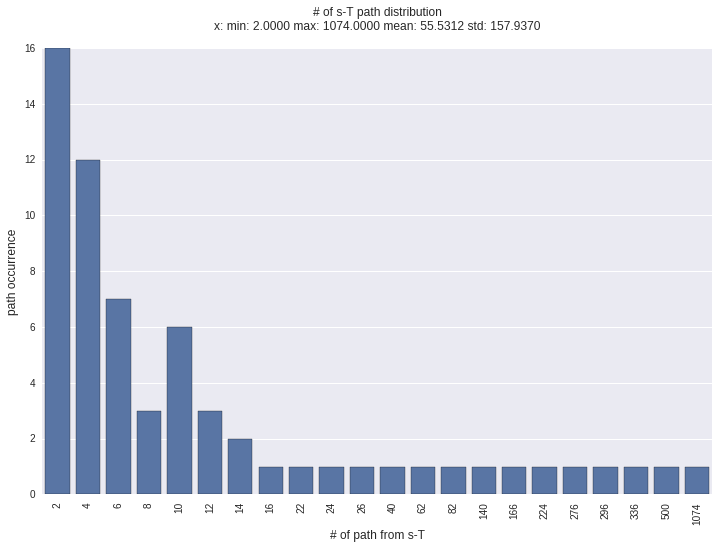

In [40]:
P_s_T_length=[sum(len(paths) for paths in t_list) for (s,t_list) in P_s_t]
print(P_s_T_length)
min_max_mean_std_hist(P_s_T_length,'# of s-T path distribution','# of path from s-T','path occurrence',0)

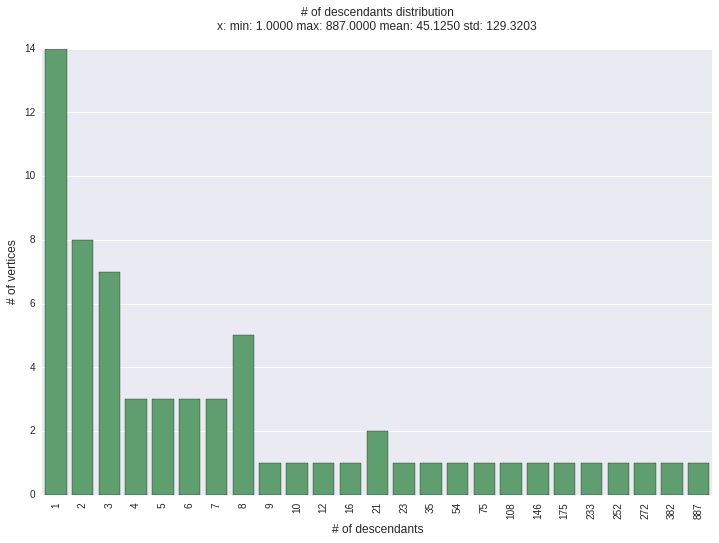

In [41]:
D_s=[(s,nx.descendants(TG,s)) for s in source_vertices]
min_max_mean_std_hist([len(d[1]) for d in D_s],'# of descendants distribution','# of descendants','# of vertices',1)



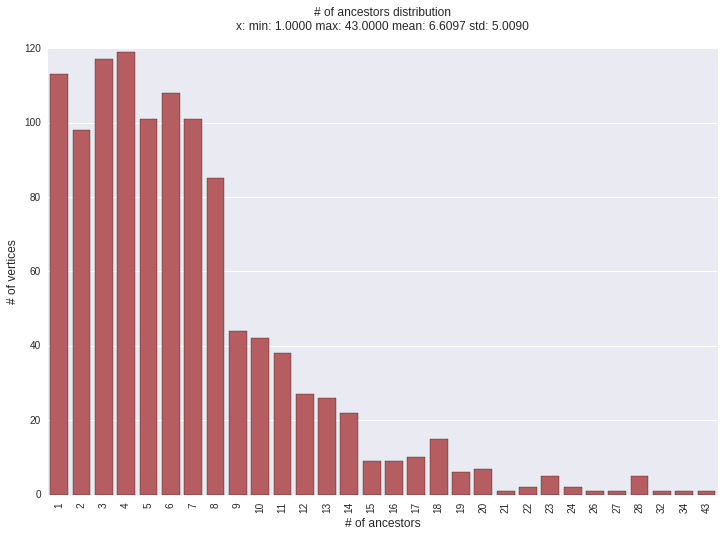

In [42]:
A_t=[(t,nx.ancestors(TG,t)) for t in terminal_vertices]
min_max_mean_std_hist([len(a[1]) for a in A_t],'# of ancestors distribution','# of ancestors','# of vertices',2)

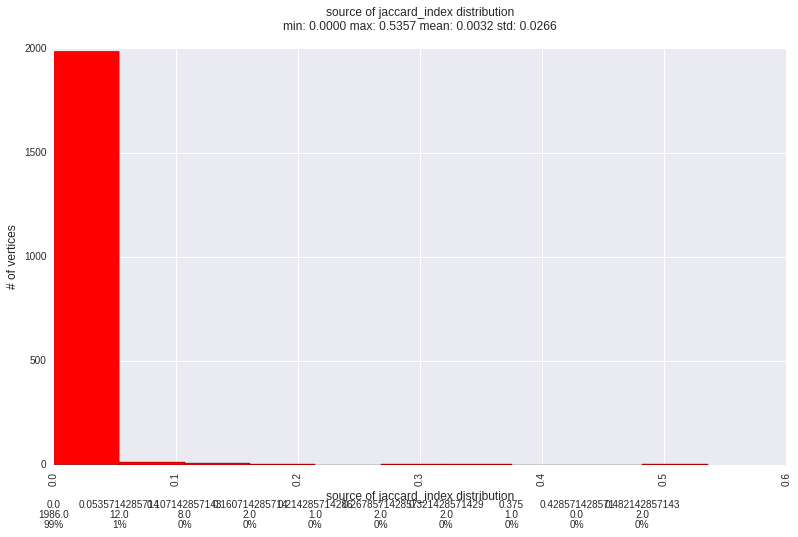

In [43]:
any_pair_of_source=findsubsets(source_vertices,2)
D_s_dict={s:nx.descendants(TG,s) for s in source_vertices}

J_D_s=[sorted(tuple)+[jaccard_index(D_s_dict[tuple[0]],D_s_dict[tuple[1]])] for tuple in any_pair_of_source]
min_max_mean_std_hist_float([jd[2] for jd in J_D_s],'source of jaccard_index distribution','source of jaccard_index distribution','# of vertices',10,'r')


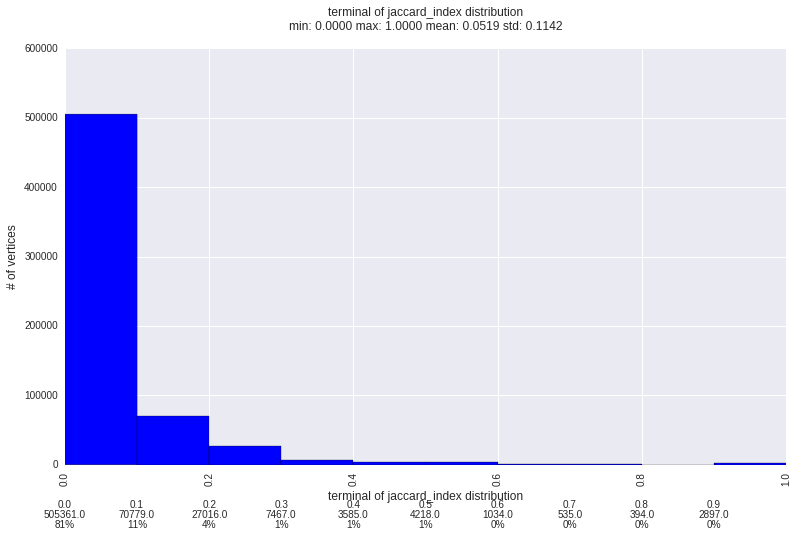

In [44]:
any_pair_of_terminal=findsubsets(terminal_vertices,2)
A_t_dict={t:nx.ancestors(TG,t) for t in terminal_vertices}
J_A_t=[sorted(tuple)+[jaccard_index(A_t_dict[tuple[0]],A_t_dict[tuple[1]])] for tuple in any_pair_of_terminal]
min_max_mean_std_hist_float([jd[2] for jd in J_A_t],'terminal of jaccard_index distribution','terminal of jaccard_index distribution','# of vertices',10,'b')

In [45]:
S_t=[(t,[s for s in source_vertices if nx.has_path(TG,s,t)]) for t in terminal_vertices]
P_t_s=[]
P_t_S_max=[]
P_t_S_min=[]
for (t,set_of_rechable_s) in S_t:
    s_list=[]
    tmp_max=[]
    tmp_min=[]
    for s in set_of_rechable_s:
        paths=[path for path in nx.all_simple_paths(TG,s,t)]
        paths_length=[len(path) for path in nx.all_simple_paths(TG,s,t)]
        t_list.append((t,paths))
        tmp_max.append(max(paths_length))
        tmp_min.append(min(paths_length))
    P_t_s.append((t,s_list))
    P_t_S_max.append(max(tmp_max))
    P_t_S_min.append(min(tmp_min))



min_max_mean_std_hist(P_t_S_max,'# max longest length of path from S-t distribution','max longest length of path from S-t','path occurrence',4)


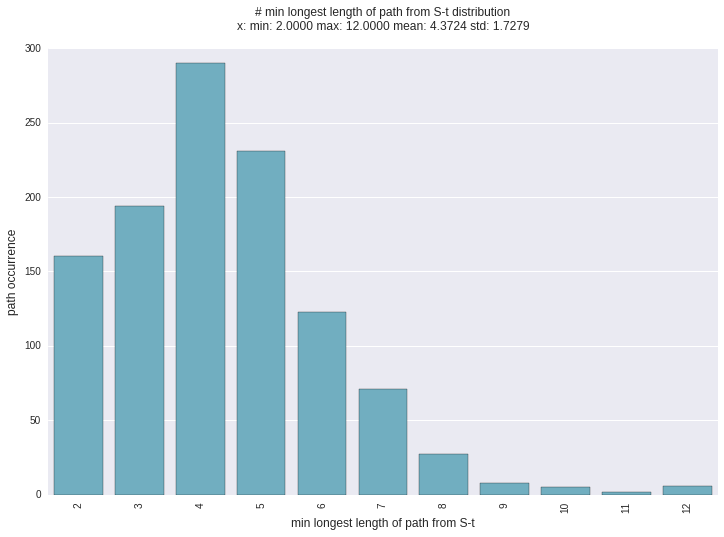

In [46]:
min_max_mean_std_hist(P_t_S_min,'# min longest length of path from S-t distribution','min longest length of path from S-t','path occurrence',5)

In [47]:
df = pd.DataFrame()
df['max']=P_t_S_max
df['min']=P_t_S_min
sns.lmplot("max", "min", data=df,fit_reg=False)
plt.show()
print(len(P_t_S_min))

1117


In [48]:
TDB=tool.load('../summary/question_topic_sorted.json')
question_cnt_over_num_labels=[]
question_cnt_over_topic_ids=[]
labels_gt_1=0
has_path=0
has_siblings=0
has_path_or_siblings=0
isolated_topics=[]
source_topics=[]
terminal_topics=[]
source_count=0
terminal_count=0
isolated_count=0
source_terminal_count=0
source_terminal_isolated_count=0
association_len=[]
for q,topics in TDB.items():
    question_cnt_over_num_labels+=[len(topics)]
    tflag=True
    sflag=True
    iflag=True
    for topic in topics:
        question_cnt_over_topic_ids.append(topic)
        if topic in isolate_vertices:
            if iflag:
                isolated_count+=1
                iflag=False
            isolated_topics.append(topic)
        elif topic in source_vertices:
            if sflag:
                source_count+=1
                sflag=False
            source_topics.append(topic)
        elif topic in terminal_vertices:
            if tflag:
                terminal_count+=1
                tflag=False
            terminal_topics.append(topic)
        
    if not sflag and not tflag:
        source_terminal_count+=1
        if not iflag:
            source_terminal_isolated_count+=1
        
    if len(topics)>1:
        labels_gt_1+=1
        subset=findsubsets(topics,2)
        p=0
        sb=0
        p_sb=0
        for comb in subset:
            if nx.has_path(TG, comb[0], comb[1]) or is_siblings(TG, comb[0], comb[1]):
                p_sb+=1
                if nx.has_path(TG, comb[0], comb[1]):
                    p+=1  
                if is_siblings(TG, comb[0], comb[1]):
                    sb+=1
        association_len.append(p_sb/len(subset))
        if p_sb>0:
            has_path_or_siblings+=1
            if sb>0:has_siblings+=1
            if p>0:has_path+=1

print('total number of questions on Training set:',len(TDB))
print('total number of source questions on Training set:',source_count)
print('total number of terminal questions on Training set:',terminal_count)
print('total number of isolated questions on Training set:',isolated_count)
print('total number of terminal and source questions on Training set:',source_terminal_count)
print('total number of terminal and source and isolated questions on Training set:',source_terminal_isolated_count)
print('total number of >=2 labels questions on Training set:',labels_gt_1)
print('total number of has path questions on Training set:',has_path)
print('total number of has siblings questions on Training set:',has_siblings)
print('total number of has path or has siblings questions on Training set:',has_path_or_siblings)
        


total number of questions on Training set: 2999967
total number of source questions on Training set: 231435
total number of terminal questions on Training set: 2079726
total number of isolated questions on Training set: 107993
total number of terminal and source questions on Training set: 118996
total number of terminal and source and isolated questions on Training set: 2031
total number of >=2 labels questions on Training set: 1999983
total number of has path questions on Training set: 1028693
total number of has siblings questions on Training set: 119717
total number of has path or has siblings questions on Training set: 1068955


In [49]:
min_max_mean_std_hist_float(association_len,'assocation/length distribution','assocation/length','# of vertices',20,'r')

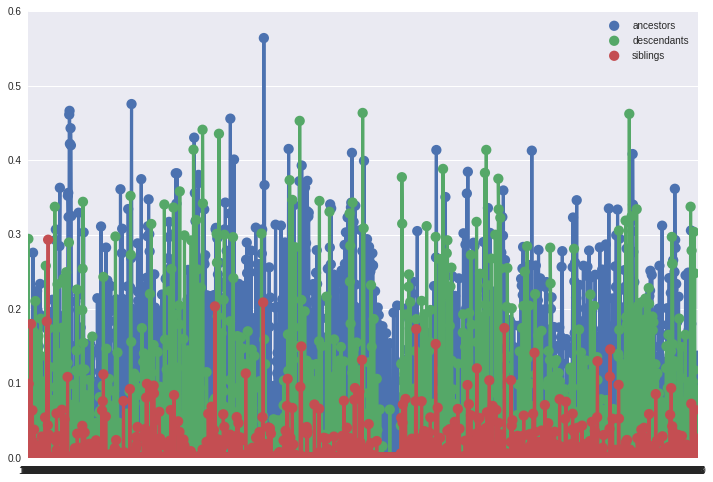

In [50]:
tds=tool.load('../summary/topic_dependency_stat.json')
new_tds={'x':[],'y':[],'c':[]}
for k in sorted(tds):
    for i in range(3):
        new_tds['x'].append(k)
        new_tds['y'].append(tds[k][i]/tds[k][-1])
        if i==0:
            new_tds['c'].append('ancestors')
        elif i==1:
            new_tds['c'].append('descendants')
        else:
            new_tds['c'].append('siblings')

#     new_tds['ancestors'].append(tds[k][0])
#     new_tds['descendants'].append(tds[k][1])
#     new_tds['siblings'].append(tds[k][2])
#     new_tds['total'].append(tds[k][3])
# for i,x in enumerate(new_tds['ancestors']):
#     if x>1:
#         print(i)
#         break
# min_max_mean_std_hist_float(new_tds['ancestors'],'ancestors freq distribution','ancestors freq','# of vertices',20,'b')
plt.figure(figsize=(12, 8))
pp=sns.pointplot(x="x", y='y', hue="c", data=new_tds)
axes = pp.axes
axes.set_ylim(0,)
# sns.barplot(new_tds['x'], new_tds['y'])
plt.show()

* ancestors： blue 
* descendants: green 
* siblings: red